In [36]:
import Modules.SQcircuit_extensions as sq_ext
import SQcircuit as sq
import qutip as qt
import numpy as np
import scipy as sp
import Modules.figures as figs
import matplotlib.pyplot as plt
import importlib

%matplotlib ipympl

importlib.reload(sq_ext)
importlib.reload(figs)
importlib.reload(sq)
np.set_printoptions(linewidth=500, formatter={'float': '{:.1e}'.format})

In [30]:
# Fundamental constants
h    = 6.626e-34
GHz = 1e9
e0   = 1.602e-19
Φ_0 = h/(2*e0)

# Single qubit

This notebook studies the qubit proposed by KIT. It's lumped element model is:
<img src='Other/Single qubit 4 nodes CC coupled to ground.jpg' width='500'>


# Circuit definitions
## Qubit

In [3]:
# Circuit parameters
Csh = 15
C   = 15
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

qubit = sq_ext.KITqubit(C, CJ, Csh, Lq, Lr, Δ, EJ)
loop = qubit.loops[0]
qubit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
sq_ext.print_flux_transformation(qubit)

Φ_1 = [ 0.00  0.00  1.00]
Φ_2 = [ 1.00  0.98  0.61]
Φ_3 = [-0.93  1.00  0.02]


# Equivalent circuits

### Equivalent circuit constructed as a fluxonium + resonator without coupling

In [6]:
loop_eq_fluxonium = sq.Loop(0.5)
loop_eq_ficticious = sq.Loop(0.5)

C_r_eq = sq.Capacitor(C / 2, 'fF')
L_r_eq = sq.Inductor(l / Lq, 'nH')

C_f_eq = sq.Capacitor(C / 2 + Csh + CJ, 'fF')
L_f_eq = sq.Inductor(l / (Lq + 4 * Lr), 'nH', loops=[loop_eq_ficticious])
JJ_f_eq = sq.Junction(EJ, 'GHz', loops=[loop_eq_fluxonium])

equiv_elements = {
    (0, 1): [C_r_eq, L_r_eq, C_f_eq, L_f_eq, JJ_f_eq],
}
qubit_unc = sq.Circuit(equiv_elements)
qubit_unc.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
qubit_unc.set_trunc_nums([50])

### Equivalent circuit constructed as a fluxonium + resonator + coupling

In [8]:
loop_eq_fluxonium = sq.Loop(0.5)
loop_eq_ficticious = sq.Loop(0.5)

C_r_eq = sq.Capacitor(C / 2, 'fF')
L_r_eq = sq.Inductor(1 / (1 / (l / Lq) - 1 / (l / Δ)), 'nH')

C_f_eq = sq.Capacitor(C / 2 + Csh + CJ, 'fF')
L_f_eq = sq.Inductor(1 / (1 / (l / (Lq + 4 * Lr)) - 1 / (l / Δ)), 'nH', loops=[loop_eq_fluxonium, loop_eq_ficticious])
JJ_f_eq = sq.Junction(EJ, 'GHz', loops=[loop_eq_fluxonium])

L_c_eq = sq.Inductor(l / Δ, 'nH')

equiv_elements = {
    (0, 1): [C_r_eq, L_r_eq],
    (1, 2): [L_c_eq],
    (0, 2): [C_f_eq, L_f_eq, JJ_f_eq],
}
qubit_equiv = sq.Circuit(equiv_elements)
qubit_equiv.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
sq_ext.print_flux_transformation(qubit_equiv)

Φ_1 = [-1.00  0.00]
Φ_2 = [ 0.02  1.00]


### Resonator

In [13]:
resonator_elements = {
    (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor (l/Lq, 'nH')],
}
resonator = sq.Circuit(resonator_elements )
resonator.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Fluxonium

In [17]:
loop_fluxonium = sq.Loop(0.5)
fluxonium_elements = {
    (0, 1): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium])],
    # (0, 1): [sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium], cap=sq.Capacitor(C/2 + Csh + CJ, 'fF'))],
}
fluxonium = sq.Circuit(fluxonium_elements)
fluxonium.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Spectrum and eigenstates

## Resonator spectrum

In [21]:
L_r = l/Lq * 1e-9
C_r = C/2 * 1e-15
w_r = 1/np.sqrt(L_r*C_r) / 2 / np.pi / 1e9
E_harm = w_r * np.arange(0,8)
E_harm

array([0.0e+00, 7.2e+00, 1.4e+01, 2.2e+01, 2.9e+01, 3.6e+01, 4.3e+01, 5.0e+01])

## Potential energy and eigenstates resoantor

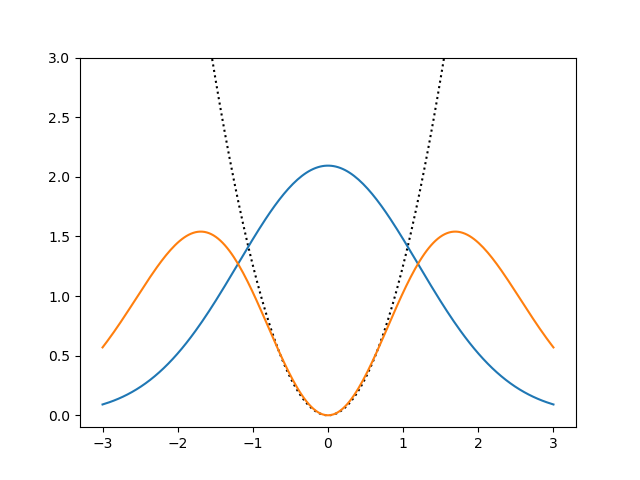

In [31]:
E_L_r = (Φ_0/(2*np.pi))**2/L_r / h

φ_r = np.linspace(-3,3,200)
n_eig = 2

V_r = 0.5 * E_L_r * (φ_r)**2

resonator.set_trunc_nums([20])
_, _ = resonator.diag(n_eig)

states_r = [resonator.eig_phase_coord(k=i, grid=[φ_r/2/np.pi]) for i in range(n_eig)]

fig, ax = plt.subplots()
ax.plot(φ_r, (V_r-V_r.min())/1e9, 'k:' )
[ax.plot(φ_r, np.abs(state)**2) for state in states_r]
ax.set_ylim([-.1,3])
fig.show()

## Potential energy and eigenstates of the fluxonium


In [23]:
L_q = l / (Lq + 4*Lr) * 1e-9
E_J = EJ * 1e9

In [24]:
E_L_f = (Φ_0/(2*np.pi))**2/L_q / h
E_C = e0**2 / (2*(C/2 + Csh + CJ)*1e-15) / h

In [25]:
print(E_L_f/GHz, E_C/GHz, E_J/GHz)

6.539994179227587 0.7594573959979404 10.0


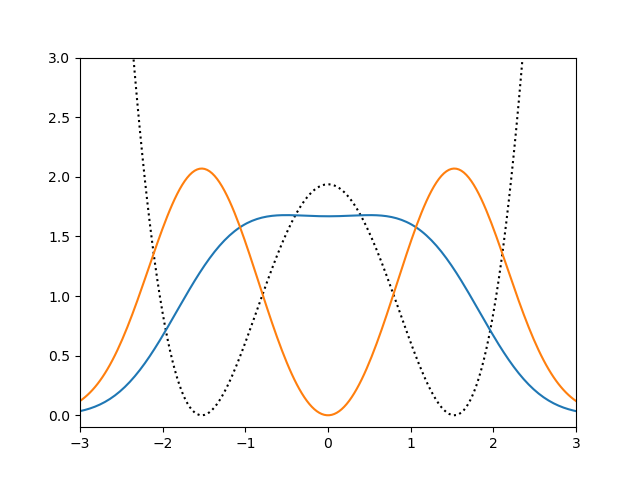

In [39]:
φ_q = np.linspace(-3,3,200)
φ_ext = np.pi
# V = 0.5 * 1/L_q * (Φ_q)**2 - E_J * np.cos((Φ_q-Φ_ext)*2*np.pi)
V = 0.5 * E_L_f * (φ_q)**2 - E_J * np.cos(φ_q-φ_ext)

n_eig = 2
fluxonium.set_trunc_nums([20])
loop_fluxonium.set_flux(φ_ext/2/np.pi)
_, _ = fluxonium.diag(n_eig)
states_f = [fluxonium.eig_phase_coord(k=i, grid=[φ_q/2/np.pi]) for i in range(n_eig)]


fig, ax = plt.subplots()
ax.plot(φ_q, (V-V.min())/1e9, 'k:' )

[ax.plot(φ_q, np.abs(state)**2) for state in states_f]
# ax.vlines(φ_min,-.1,3)
ax.set_ylim([-.1,3])
figs.export('Fluxonium eigenstates.pdf')
fig.show()

## Spectrum vs external flux

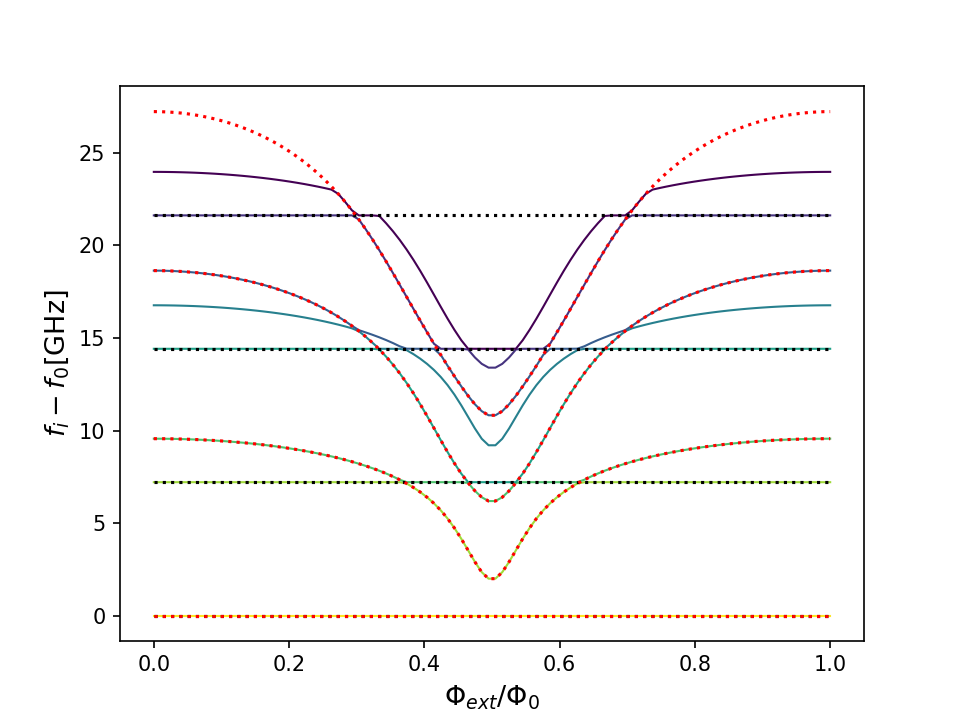

In [41]:
qubit.set_trunc_nums([1, 10, 15])
fluxonium.set_trunc_nums([15])

# spectrum of the qubit
phi = np.linspace(0,1,100)
# phi = np.linspace(0.36,0.38,500)
n_eig=8
spec = np.zeros((n_eig, len(phi)))
E_qubit = np.zeros((n_eig, len(phi)))

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))
for i in range(len(phi)):
    # set the external flux for the loop
    loop_fluxonium.set_flux(phi[i])
    loop.set_flux(phi[i])
    # diagonalize the qubit
    spec[:, i] = qubit.diag(n_eig)[0]
    E_qubit[:, i] = fluxonium.diag(n_eig)[0]

fig, ax = plt.subplots(dpi=150)
for i in range(n_eig):
    ax.plot(phi, spec[i,:]- spec[0,:], color=eig_colors[i], linewidth=1)
for i in range(n_eig//2):
    ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' )
    ax.plot(phi, E_qubit[i,:]- E_qubit[0,:], color='r', linestyle = ':')

ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
ax.set_ylabel(r"$f_i-f_0$[GHz]", fontsize=13)
# ax.set_ylim(7,7.5)
fig.show()
figs.export('Spectrum.pdf')

## Eigenstates of the qubit in phase base

In [37]:
qubit.set_trunc_nums([1,15,15])

# creat the phase grid
phi1 = 0
phi2 = np.linspace(-0.005, 0.005, 100)
phi3 = np.linspace(-0.5, 0.5  , 100)
grid = [phi1, phi2, phi3]

state0_vs_ext_flux = []
state1_vs_ext_flux = []
state2_vs_ext_flux = []
state3_vs_ext_flux = []

ext_flux_list = [0.5, 0.55, 0.65, 1]
# loop thorugh several values of external flux
for ext_flux in ext_flux_list:
    loop.set_flux(ext_flux)
    _, _ = qubit.diag(n_eig=5)

    # Calculate eigenstates in phase coord
    state0_vs_ext_flux.append(qubit.eig_phase_coord(0, grid=grid))
    state1_vs_ext_flux.append(qubit.eig_phase_coord(1, grid=grid))
    state2_vs_ext_flux.append(qubit.eig_phase_coord(2, grid=grid))
    state3_vs_ext_flux.append(qubit.eig_phase_coord(3, grid=grid))

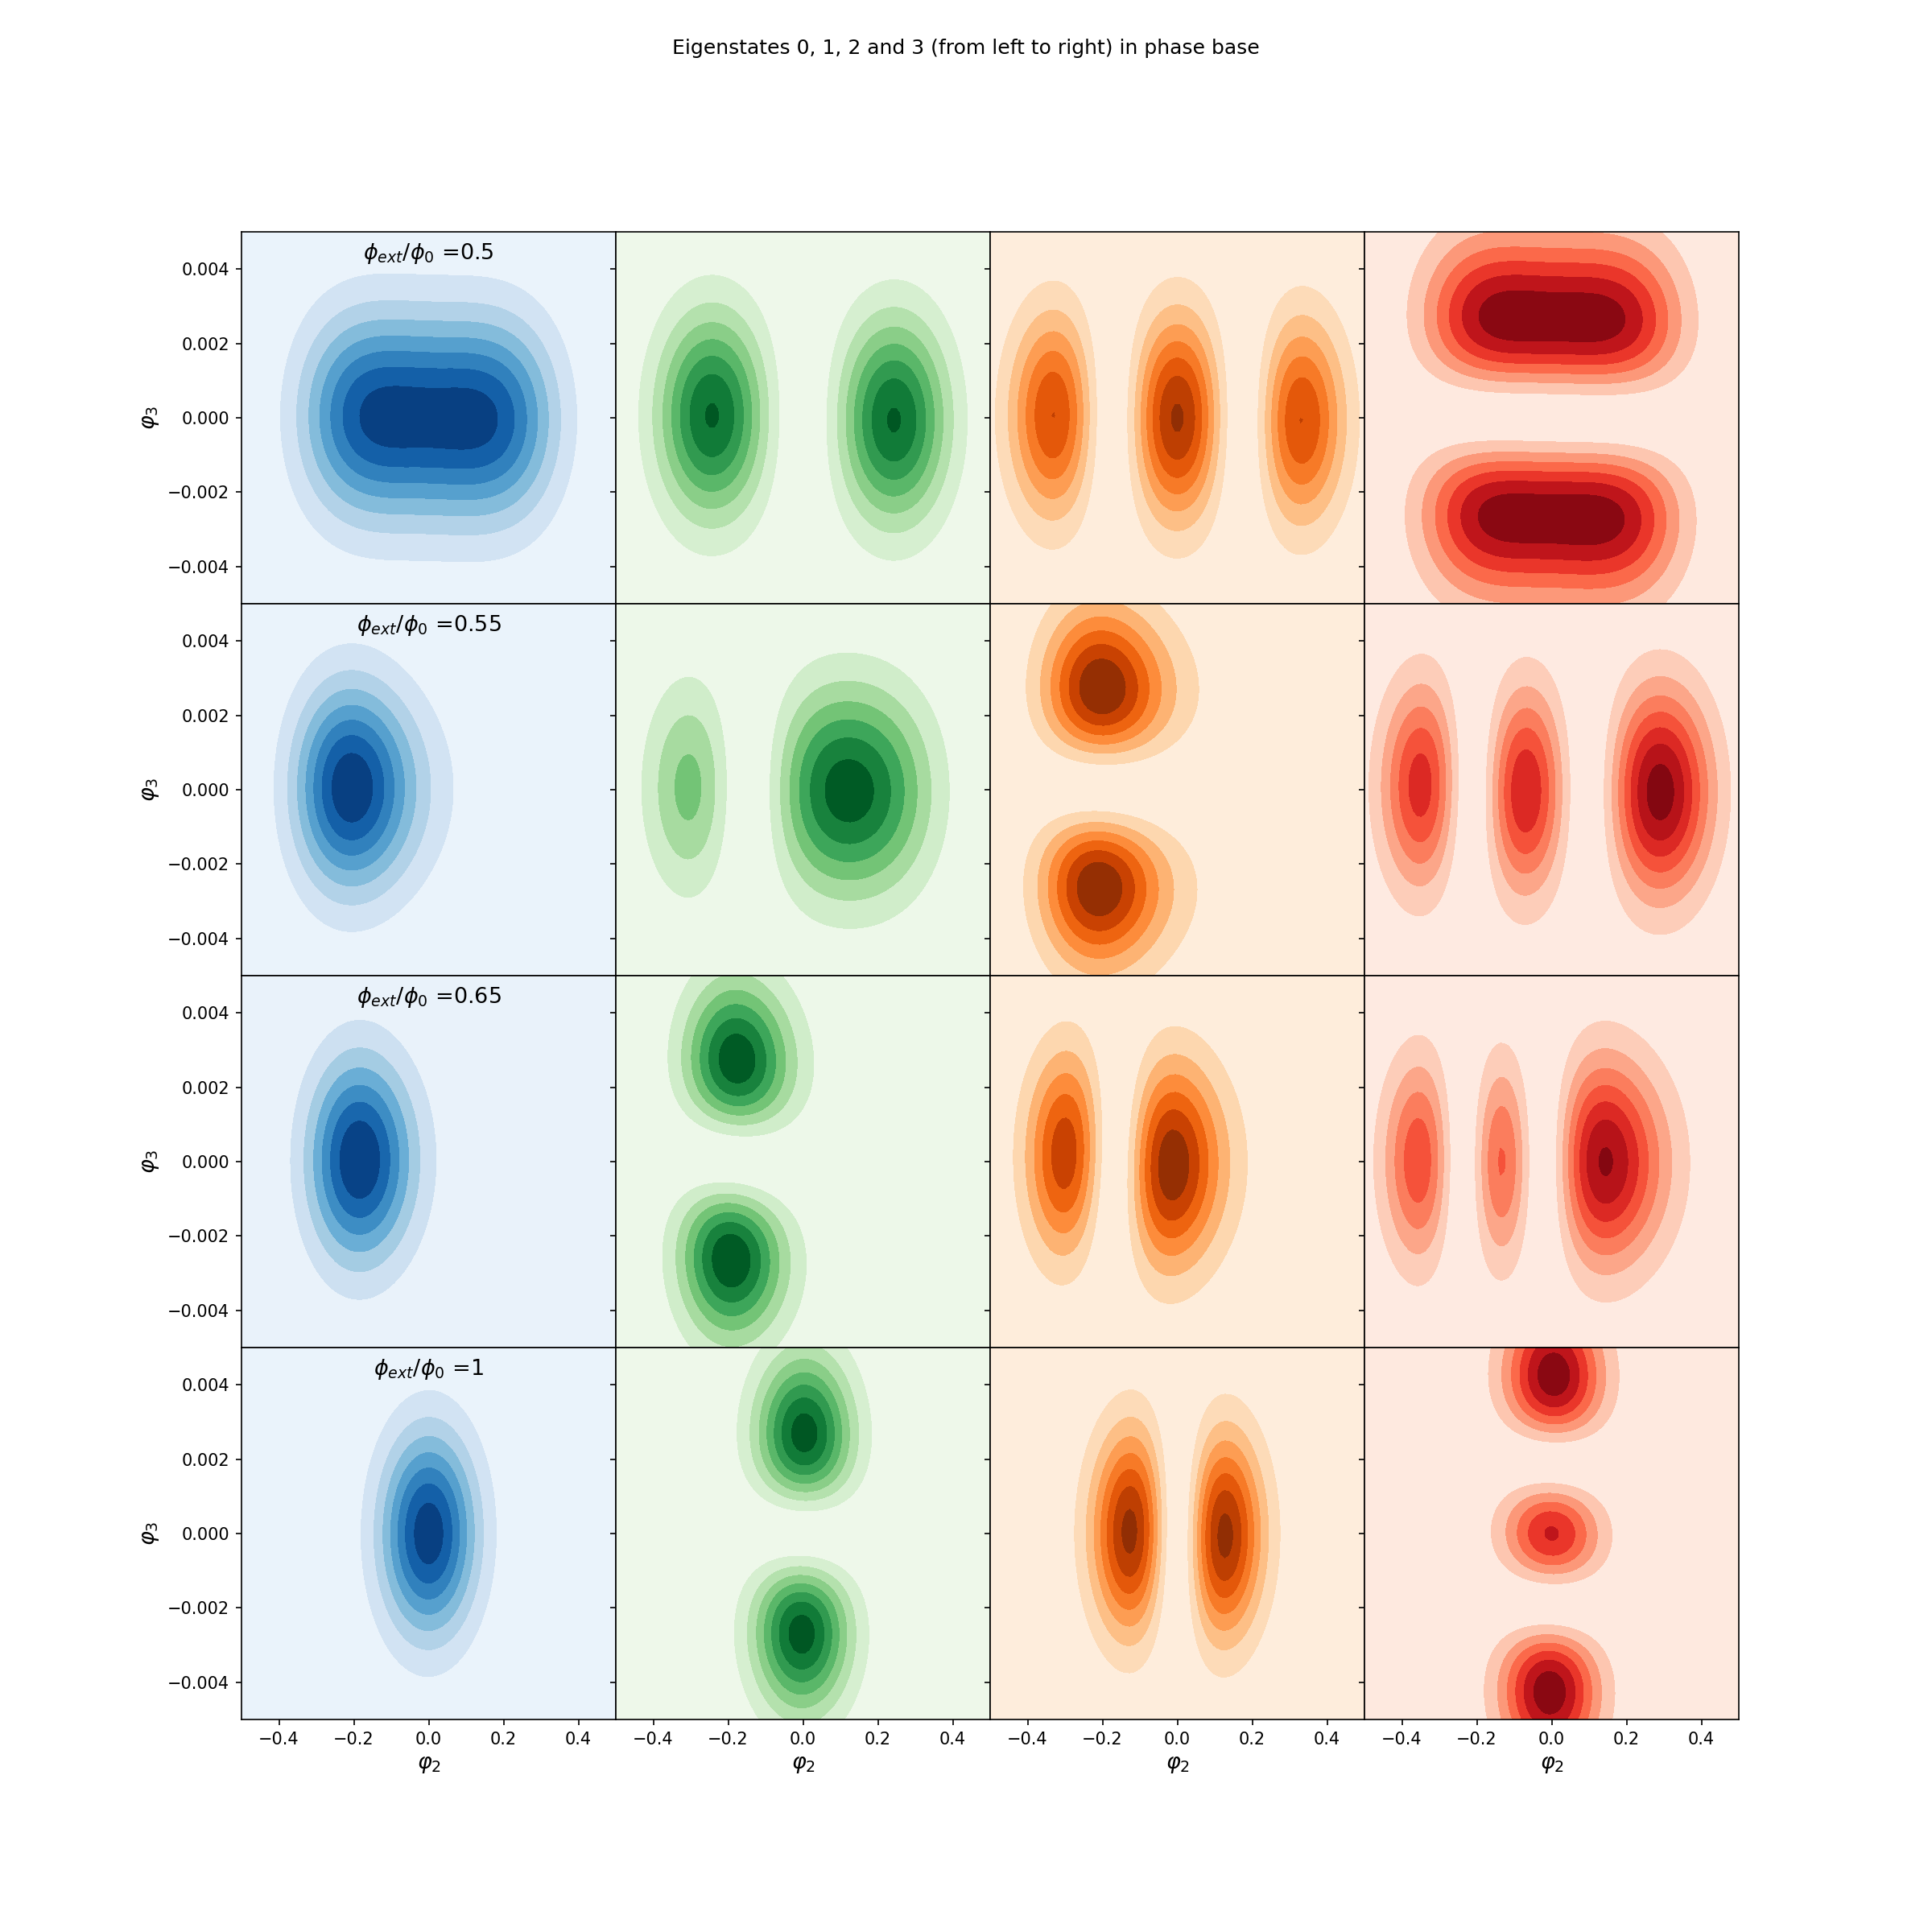

In [38]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4), sharey='row', sharex = 'col', dpi=150)

for i, ext_flux in enumerate(ext_flux_list):
    axs[i, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues", )
    axs[i, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Greens" )
    axs[i, 2].contourf(phi3, phi2, np.abs(state2_vs_ext_flux[i].T) ** 2, cmap="Oranges")
    axs[i, 3].contourf(phi3, phi2, np.abs(state3_vs_ext_flux[i].T) ** 2, cmap="Reds"   )
    for j in range(4):
        axs[-1, j].set_xlabel(r"$\varphi_2$", fontsize=13)
    axs[i, 0].set_ylabel(r"$\varphi_3$", fontsize=13)
    axs[i, 0].set_title('$\phi_{ext}/\phi_{0}$ ='+f'{ext_flux}', fontsize=13, y=0.9 )
fig.suptitle('Eigenstates 0, 1, 2 and 3 (from left to right) in phase base')
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
plt.show()

# Fluxonium-Resonator internal coupling in KIT's qubit

In [39]:
fluxonium.set_trunc_nums([15])
resonator.set_trunc_nums([15])
loop_fluxonium.set_flux(0.5)
loop.set_flux(0.5)
_ = qubit.diag(2)
_ = fluxonium.diag(2)
_ = resonator.diag(2)

In [40]:
Δ01 = (qubit.efreqs[1]-qubit.efreqs[0])
Δ01

1.9453602983438003

In [41]:
L_c = l / Δ * 1e-9
E_L_c = (Φ_0/(2*np.pi))**2/L_c / h / GHz
E_L_c

0.01006152950650398

In [42]:
Φ_f = sq_ext.decomposition_in_pauli_2x2(fluxonium.flux_op(0, basis='eig').__array__())[1]
Φ_f

C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i] = 0.5 * np.trace(s[i].T.conjugate() @ A)


38.41921243891211

In [43]:
Φ_r = sq_ext.decomposition_in_pauli_2x2(resonator.flux_op(0, basis='eig').__array__())[1]
Φ_r

38.365883888556986

In [72]:
g = Φ_r * Φ_f / L_c / GHz
g

0.0907091278259839

In [73]:
g / Δ01 * 100

4.66314063751776

### Analytical approximation of the fluxonim-resonator coupling

In [74]:
dVdφ =  lambda φ: E_L_f*φ + E_J*np.sin(φ+np.pi)
φ_min = sp.optimize.fsolve(dVdφ, 1)[0]
φ_min

1.527628932582084

In [80]:
Φ_f_an =(Φ_0 / 2*np.pi) * φ_min
Φ_f_an

483.2352418014397

In [81]:
Φ_r_an = np.sqrt(sq.hbar/2 * np.sqrt(L_r/C_r))
Φ_r_an

38.36589667717856

In [83]:
g_an = Φ_f_an * Φ_r_an /L_c / h /GHz
g_an

1.1409359835150057

In [84]:
g_an / Δ01 * 100

58.652806801776855

# Alternative method to calculate the coupling

In [155]:
qubit.set_trunc_nums([1, 5, 10])
resonator.set_trunc_nums([5])
fluxonium.set_trunc_nums([10])

In [159]:
H = qubit.hamiltonian()
H_r = resonator.hamiltonian()
H_f = fluxonium.hamiltonian()
H

Quantum object: dims = [[5, 10], [5, 10]], shape = (50, 50), type = oper, isherm = True
Qobj data =
[[4.9e+10 0.0e+00 -1.7e+10 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 6.5e+10 0.0e+00 ... -2.1e+00 0.0e+00 1.7e-01]
 [-1.7e+10 0.0e+00 8.7e+10 ... 0.0e+00 -3.9e+00 0.0e+00]
 ...
 [0.0e+00 -2.1e+00 0.0e+00 ... 4.4e+11 0.0e+00 -4.2e+10]
 [0.0e+00 0.0e+00 -3.9e+00 ... 0.0e+00 4.5e+11 0.0e+00]
 [0.0e+00 1.7e-01 0.0e+00 ... -4.2e+10 0.0e+00 5.3e+11]]

In [160]:
H_u = qt.tensor(H_r, qt.qeye(fluxonium.m )) + qt.tensor(qt.qeye(resonator.m), H_f)
H_u

Quantum object: dims = [[5, 10], [5, 10]], shape = (50, 50), type = oper, isherm = True
Qobj data =
[[4.9e+10 0.0e+00 -1.7e+10 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 6.5e+10 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [-1.7e+10 0.0e+00 8.7e+10 ... 0.0e+00 0.0e+00 0.0e+00]
 ...
 [0.0e+00 0.0e+00 0.0e+00 ... 4.4e+11 0.0e+00 -4.2e+10]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 4.5e+11 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... -4.2e+10 0.0e+00 5.3e+11]]

In [183]:
H_c = H.transform(H_u.eigenstates()[1]) - H_u
H_c

Quantum object: dims = [[5, 10], [5, 10]], shape = (50, 50), type = oper, isherm = True
Qobj data =
[[-7.2e+09 0.0e+00 1.7e+10 ... 6.0e-01 -5.4e+01 0.0e+00]
 [0.0e+00 -1.1e+10 0.0e+00 ... 0.0e+00 0.0e+00 8.3e-01]
 [1.7e+10 0.0e+00 -5.9e+09 ... -3.3e+00 -5.6e+02 0.0e+00]
 ...
 [6.0e-01 0.0e+00 -3.3e+00 ... 2.7e+10 -7.9e+08 4.2e+10]
 [-5.4e+01 0.0e+00 -5.6e+02 ... -7.9e+08 5.5e+10 0.0e+00]
 [0.0e+00 8.3e-01 0.0e+00 ... 4.2e+10 0.0e+00 2.1e+10]]

In [235]:
eigs_H_u = np.array( [ eig.__array__()[:,0] for eig in H_u.eigenstates()[1] ] ) 
eigs_H_c = np.array( [ eig.__array__()[:,0] for eig in H_c.eigenstates()[1] ] )


In [238]:
sq_ext.H_eff_SWT_eigs(eigs_H_u, eigs_H_c, H_u.eigenenergies())

array([[ 1.64015940e+11+0.j,  2.52574204e+09+0.j, -4.53846984e+10+0.j, ...,  2.23568213e+06+0.j, -3.45352578e+07+0.j, -1.57727046e+07+0.j],
       [ 2.52574204e+09+0.j,  2.05411262e+11+0.j,  1.18271095e+09+0.j, ..., -3.32548658e+07+0.j, -5.32696592e+05+0.j,  4.16558641e+07+0.j],
       [-4.53846984e+10+0.j,  1.18271095e+09+0.j,  2.34211510e+11+0.j, ..., -9.10821563e+07+0.j,  1.10619557e+08+0.j,  5.12603011e+07+0.j],
       ...,
       [ 2.23568213e+06+0.j, -3.32548658e+07+0.j, -9.10821563e+07+0.j, ...,  2.95973897e+11+0.j,  3.92431775e+09+0.j, -3.28691960e+10+0.j],
       [-3.45352578e+07+0.j, -5.32696592e+05+0.j,  1.10619557e+08+0.j, ...,  3.92431775e+09+0.j,  3.66482801e+11+0.j, -9.16278169e+09+0.j],
       [-1.57727046e+07+0.j,  4.16558641e+07+0.j,  5.12603011e+07+0.j, ..., -3.28691960e+10+0.j, -9.16278169e+09+0.j,  3.75972566e+11+0.j]])